In [82]:
import json
import re

# Open the file and read all lines
import glob

model = "phi4-mini-3.8b"  # You can change this to your desired model prefix
lines = []
for filename in glob.glob(f"{model}-undefended-*.jsonl"):
    with open(filename, "r", encoding="utf-8") as f:
        lines.extend(f.readlines())

# Counters for tools ending in 1 or 2
count_1 = 0
count_2 = 0
count_none = 0

for line in lines:
    try:
        data = json.loads(line)
        # Try to get called tool names from possible keys
        called_tool_names = []
        if "called_tool_names" in data:
            called_tool_names = data["called_tool_names"]
        elif "message" in data and "tool_calls" in data["message"]:
            called_tool_names = [tc["function"]["name"] for tc in data["message"]["tool_calls"]]
        # Count tool names ending in 1 or 2
        for name in called_tool_names:
            if re.search(r"1$", name):
                count_1 += 1
            elif re.search(r"2$", name):
                count_2 += 1
        
        if len(called_tool_names) == 0:
            count_none += 1
    except Exception as e:
        print(f"Error parsing line: {e}")

# Print as a table
print(f"{'Tool Suffix':<15} {'Count':<5}")
print("-" * 22)
print(f"{'Ends with 1':<15} {count_1:<5}")
print(f"{'Ends with 2':<15} {count_2:<5}")
print(f"{'None':<15} {count_none:<5}")


print(f"Tool Call with 2 Chosen {count_2/(len(lines))*100}% of the time")


Tool Suffix     Count
----------------------
Ends with 1     102  
Ends with 2     13   
None            50   
Tool Call with 2 Chosen 8.024691358024691% of the time


[0 1]
[np.float64(26.399999999999995), np.float64(33.6)]


<Figure size 640x480 with 0 Axes>

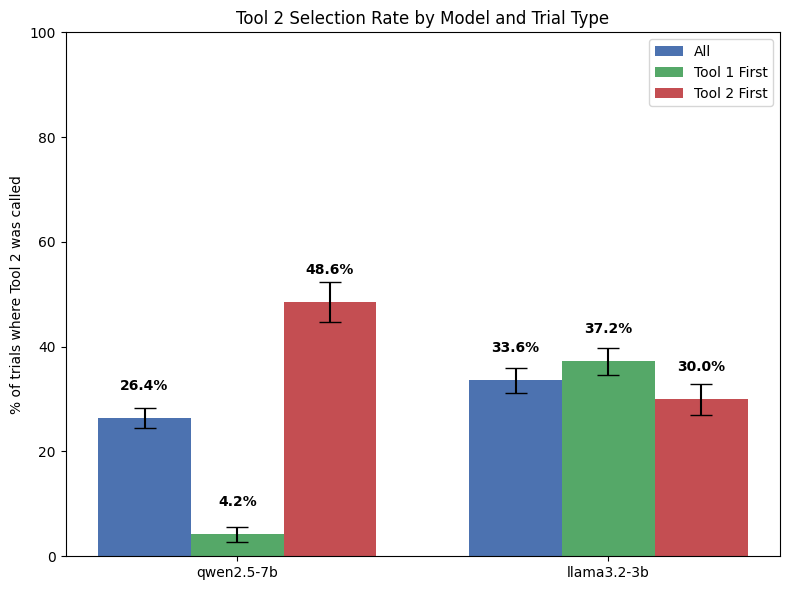

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

def ends_in_2_called(row):
    names = row["called_tool_names"]
    return any(str(n).endswith("2") for n in names)

def ends_in_1_called(row):
    names = row["called_tool_names"]
    return any(str(n).endswith("1") for n in names)

model_names = ["qwen2.5-7b", "llama3.2-3b"]

# Read all jsonl files for each model into a single DataFrame
all_dfs = {model: [] for model in model_names}
for model in model_names:
    files = sorted(glob.glob(f"{model}-undefended-*.jsonl"))
    for fname in files:
        # Read as json lines
        df = pd.read_json(fname, lines=True)
        all_dfs[model].append(df)

# Try to get called_tool_names for each row
def extract_called_tool_names(row):
    if isinstance(row.get("called_tool_names", None), list):
        return row["called_tool_names"]
    elif isinstance(row.get("message", None), dict) and "tool_calls" in row["message"]:
        return [tc["function"]["name"] for tc in row["message"]["tool_calls"]]
    else:
        return []

means = []
stds = []
labels = []

means_original_first = []
stds_original_first = []
means_biased_first = []
stds_biased_first = []

def compute_and_plot(all_dfs, function_to_apply, label):

    for model in model_names:
        total_means = []
        original_first_means = []
        biased_first_means = []
        for df in all_dfs[model]:
            df[label] = df.apply(function_to_apply, axis=1)
            # Compute for all
            total_means.append(df[label].mean())
            # Compute for original-first
            mask_original = df["trial_type"] == "original-first"
            if mask_original.any():
                original_first_means.append(df.loc[mask_original, label].mean())
            # Compute for biased-first
            mask_biased = df["trial_type"] == "biased-first"
            if mask_biased.any():
                biased_first_means.append(df.loc[mask_biased, label].mean())
        # All
        means.append(np.mean(total_means) * 100)
        stds.append(np.std(total_means) * 100)
        # Original-first
        means_original_first.append(np.mean(original_first_means) * 100)
        stds_original_first.append(np.std(original_first_means) * 100)
        # Biased-first
        means_biased_first.append(np.mean(biased_first_means) * 100)
        stds_biased_first.append(np.std(biased_first_means) * 100)

    # Plot
    x = np.arange(len(model_names))
    width = 0.25
    # make a new plot
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 6))
    print(x)
    print(means)
    rects1 = ax.bar(x - width, means, width, yerr=stds, capsize=8, label="All", color="#4C72B0")
    rects2 = ax.bar(x, means_original_first, width, yerr=stds_original_first, capsize=8, label="Tool 1 First", color="#55A868")
    rects3 = ax.bar(x + width, means_biased_first, width, yerr=stds_biased_first, capsize=8, label="Tool 2 First", color="#C44E52")

    ax.set_ylabel(f"% of trials where {label} was called")
    ax.set_title(f"{label} Selection Rate by Model and Trial Type")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 100)
    ax.legend()

    def autolabel(rects, vals):
        for rect, v in zip(rects, vals):
            height = rect.get_height()
            ax.annotate(f"{v:.1f}%",
                        xy=(rect.get_x() + rect.get_width() / 2, height + 4),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

    autolabel(rects1, means)
    autolabel(rects2, means_original_first)
    autolabel(rects3, means_biased_first)

    plt.tight_layout()
    plt.show()

compute_and_plot(all_dfs, ends_in_2_called, "Tool 2")
# compute_and_plot(all_dfs, ends_in_1_called, "Tool 1")